In [1]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 57.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.07MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.2MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.05MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

In [9]:
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

In [8]:
print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


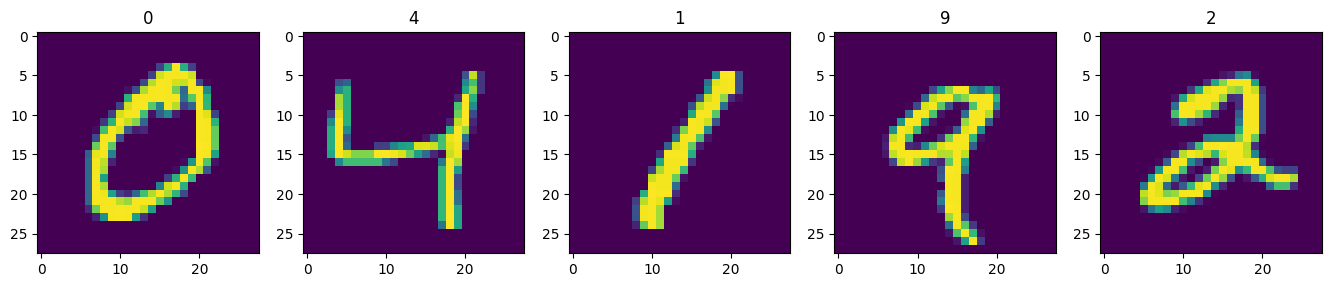

In [10]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()


In [11]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [12]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
if (torch.cuda.is_available()):
    model.cuda()

no_epochs = 10
train_loss = list()
val_loss = list()
best_val_loss = 1
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")


Epoch: 1/10, Train Loss: 0.27766807, Val Loss: 0.05111097, Val Accuracy: 0.98344444
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.05111097

Epoch: 2/10, Train Loss: 0.09500147, Val Loss: 0.03569119, Val Accuracy: 0.98733333
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03569119

Epoch: 3/10, Train Loss: 0.07158500, Val Loss: 0.03331354, Val Accuracy: 0.98788889
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03331354

Epoch: 4/10, Train Loss: 0.05865020, Val Loss: 0.03148712, Val Accuracy: 0.98900000
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.03148712

Epoch: 5/10, Train Loss: 0.04986404, Val Loss: 0.02895903, Val Accuracy: 0.99066667
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02895903

Epoch: 6/10, Train Loss: 0.04326362, Val Loss: 0.02667885, Val Accuracy: 0.99155556
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.02667885

Epoch: 7/

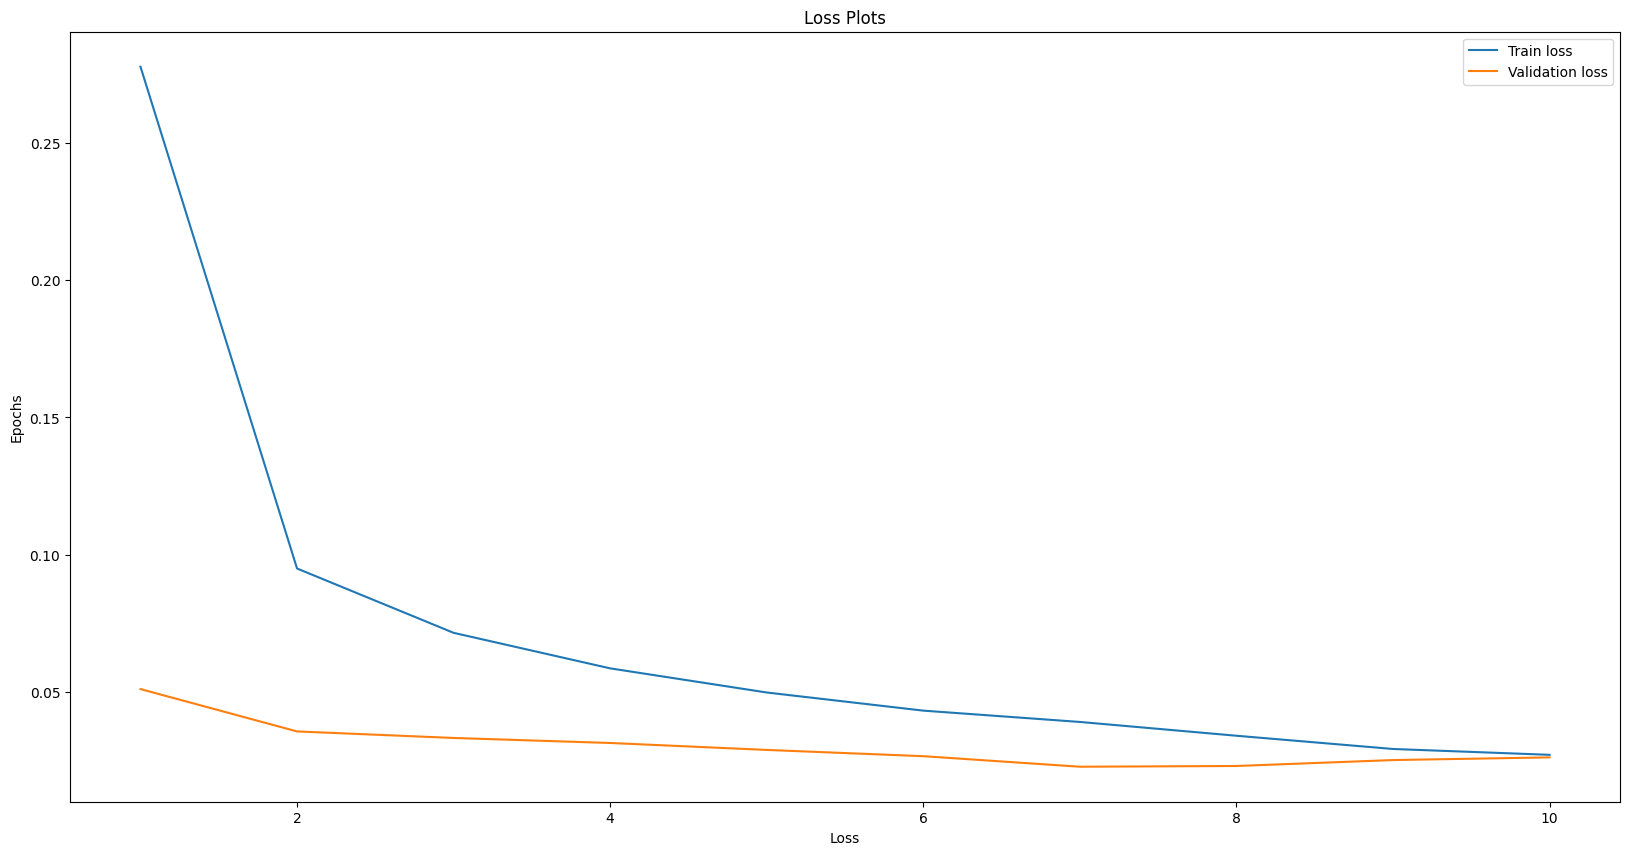

In [14]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
# plt.show()
plt.savefig('loss.png')

In [15]:
torch.cuda.is_available()


False

Using device: cpu


<ipython-input-30-c176ffb349cf>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.dth"))


Độ chính xác trên tập test: 0.99300000


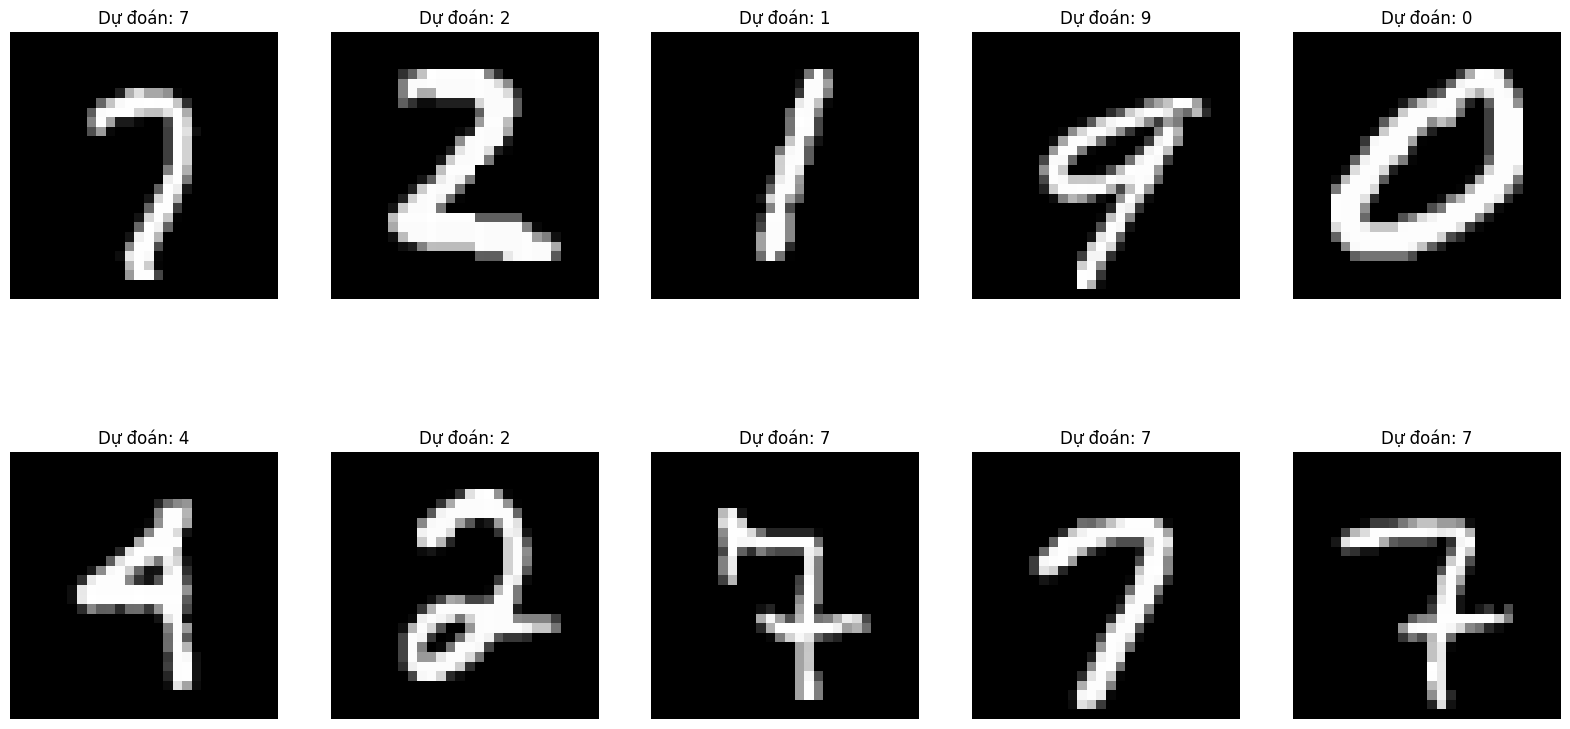

In [30]:
# Định nghĩa thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Tải model
model.load_state_dict(torch.load("model.dth"))
model.eval()

# Khởi tạo danh sách kết quả và bộ đếm
results = []
total_correct = 0
total_samples = 0

# Đánh giá model
for itr, (images, labels) in enumerate(test_dataloader):
    images, labels = images.to(device), labels.to(device)  # Đưa dữ liệu vào đúng thiết bị (CPU/GPU)
    preds = model(images)
    preds = torch.nn.functional.softmax(preds, dim=1)

    for i, p in enumerate(preds):
        predicted_label = torch.argmax(p).item()
        actual_label = labels[i].item()

        # Kiểm tra dự đoán có đúng không
        if predicted_label == actual_label:
            total_correct += 1
        total_samples += 1

        # Lưu hình ảnh và kết quả dự đoán để hiển thị
        results.append((images[i].cpu(), predicted_label))

# Tính độ chính xác
test_accuracy = total_correct / total_samples
print(f'Độ chính xác trên tập test: {test_accuracy:.8f}')

# Hiển thị một số kết quả
fig = plt.figure(figsize=(20, 10))
to_pil = transforms.ToPILImage()

for i in range(10):  # Hiển thị 10 kết quả đầu tiên
    img, pred_label = results[i]
    img = to_pil(img.squeeze(0))  # Chuyển tensor thành hình ảnh PIL

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(f'Dự đoán: {pred_label}')
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.show()
